In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter

def calculate_insurance_payout(temperature_data, threshold_for_heatwave, TSI):
    total_payout = 0.0
    for i in range(len(temperature_data) - 6):
        if temperature_data[i] > threshold_for_heatwave:
            count = 1
            for j in range(i+1, i+7):
                if temperature_data[j] <= threshold_for_heatwave:
                    break 
                count += 1
            if count == 7:
                total_payout = total_payout + 0.05 * TSI  
    return total_payout

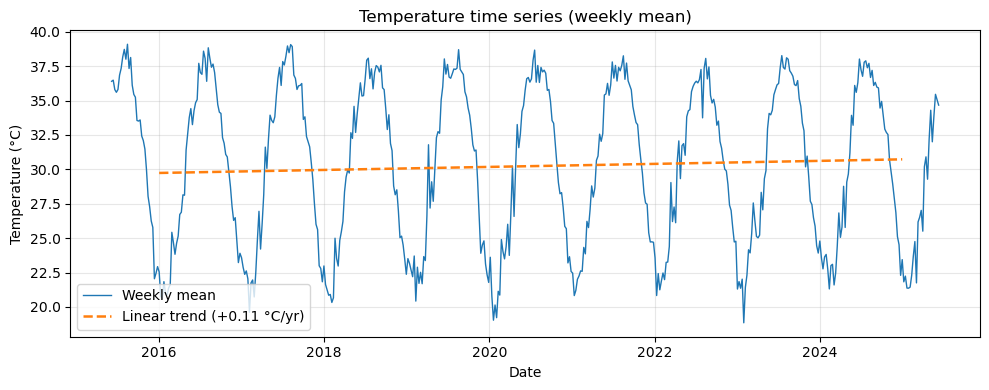

In [29]:
# Load data
df = pd.read_excel(
    "Temperature_Analysis_Exercice_NF.xlsx",
    sheet_name="Hourly Data (Daytime)",
    header=2  # ensure the first real header row is used
)

df = df.copy()
df['year'] = pd.to_numeric(df['year'], errors='coerce').astype('Int64')
df['month'] = pd.to_numeric(df['month'], errors='coerce').astype('Int64')
df['temperature_C'] = pd.to_numeric(df['temperature_C'], errors='coerce')
df['dt'] = pd.to_datetime(df['datetime_str'])
df = df.sort_values('dt')

weekly = df.set_index('dt')['temperature_C'].resample('W').mean()

# Plot the time series
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(weekly.index, weekly.values, linewidth=1, label='Weekly mean')
ax.set_xlabel('Date'); ax.set_ylabel('Temperature (°C)')
ax.set_title('Temperature time series (weekly mean)')
ax.grid(True, alpha=0.3)

# 2) Fit and draw a linear trend (°C/year)
start, end = '2016-01-01', '2024-12-31'
weekly_slice = weekly.loc[start:end].dropna() # only use data from years when we have full data
x = mdates.date2num(weekly_slice.index.to_pydatetime()).astype(float)   # days as float
y = weekly_slice.values.astype(float)
mask = ~np.isnan(y)
m, b = np.polyfit(x[mask], y[mask], 1)                            # y ≈ m*x + b
slope_per_year = m * 365.25

xx = np.array([x[mask].min(), x[mask].max()])
ax.plot(mdates.num2date(xx), m*xx + b, '--', linewidth=1.8,
        label=f'Linear trend ({slope_per_year:+.2f} °C/yr)')

ax.legend()
plt.tight_layout()
plt.show()

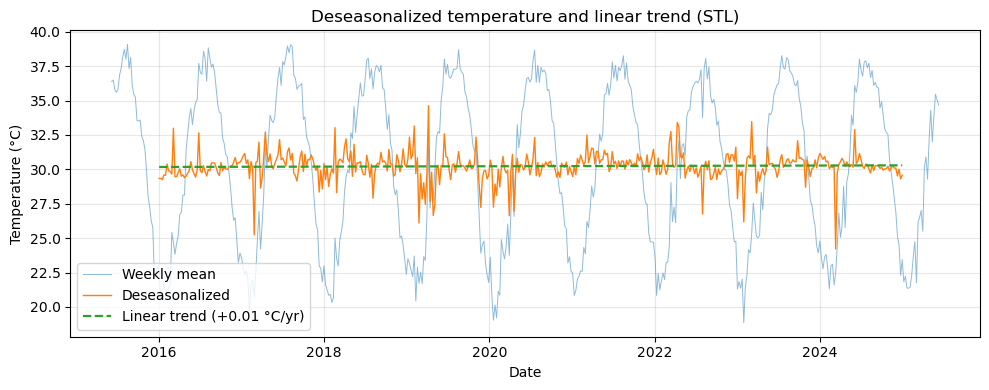

In [30]:
from statsmodels.tsa.seasonal import STL
# Deseasonalize trend 
weekly_slice = weekly_slice.interpolate(limit_direction='both')

# STL decomposition (seasonal period ~ 52 weeks)
res = STL(weekly_slice, period=52, robust=True).fit()
trend = res.trend
seasonal = res.seasonal
deseasonalized = weekly_slice - seasonal  # (= trend + resid)

# fit linear trend on the deseasonalized series (°C/year)
x = mdates.date2num(deseasonalized.index.to_pydatetime()).astype(float)  # days
y = deseasonalized.values.astype(float)
m, b = np.polyfit(x[~np.isnan(y)], y[~np.isnan(y)], 1)
slope_per_year = m * 365.25

# Plot
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(weekly.index, weekly.values, linewidth=0.7, alpha=0.5, label='Weekly mean')
ax.plot(deseasonalized.index, deseasonalized.values, linewidth=1.0, label='Deseasonalized')
xx = np.array([x.min(), x.max()])
ax.plot(mdates.num2date(xx), m*xx + b, '--', linewidth=1.6,
        label=f'Linear trend ({slope_per_year:+.2f} °C/yr)')
ax.set_xlabel('Date'); ax.set_ylabel('Temperature (°C)')
ax.set_title('Deseasonalized temperature and linear trend (STL)')
ax.grid(True, alpha=0.3); ax.legend(); plt.tight_layout(); plt.show()

/var/folders/my/7zs3bwd5187d9h06fcjxvlkr0000gn/T/ipykernel_49372/566755822.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  slopes_mean = ym_mean.groupby('month').apply(


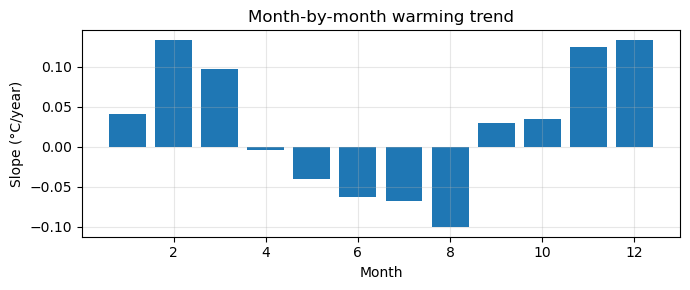

In [31]:
# Method A: Seasonal linear trend (OLS) per month.
ym_mean = df.groupby(['year','month'])['temperature_C'].mean().reset_index()
slopes_mean = ym_mean.groupby('month').apply(
    lambda g: np.polyfit(g['year'], g['temperature_C'], 1)[0]
) 

df1 = df.copy()
df1 = df1.merge(slopes_mean.rename('slope'), on='month')
base_year = df1['year'].min()
df1['temp_adj'] = df1['temperature_C'] - df1['slope'] * (df1['year'] - base_year)

fig, ax = plt.subplots(figsize=(7,3))
ax.bar(slopes_mean.index, slopes_mean.values)
ax.set_xlabel('Month'); ax.set_ylabel('Slope (°C/year)')
ax.set_title('Month-by-month warming trend'); ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

/var/folders/my/7zs3bwd5187d9h06fcjxvlkr0000gn/T/ipykernel_49372/2373347850.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  slopes_95 = ym_q95.groupby('month').apply(


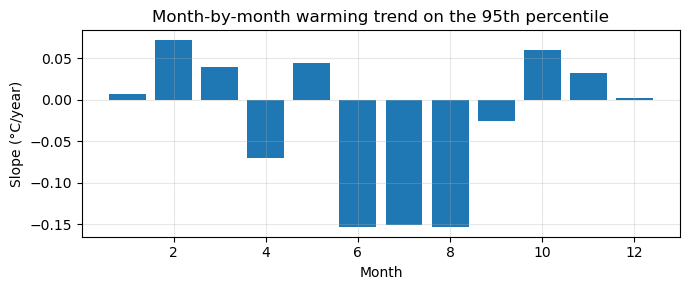

In [32]:
# Method B: Tail-focused detrending (heatwave relevance).
ym_q95 = df.groupby(['year','month'])['temperature_C'].quantile(0.95).reset_index()
slopes_95 = ym_q95.groupby('month').apply(
    lambda g: np.polyfit(g['year'], g['temperature_C'], 1)[0]
).rename('slope_95')


df = df.merge(slopes_95, on='month')
base_year = df['year'].min()
df['temp_adj'] = df['temperature_C'] - df['slope_95'] * (df['year'] - base_year)

fig, ax = plt.subplots(figsize=(7,3))
ax.bar(slopes_95.index, slopes_95.values)
ax.set_xlabel('Month'); ax.set_ylabel('Slope (°C/year)')
ax.set_title('Month-by-month warming trend on the 95th percentile'); ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

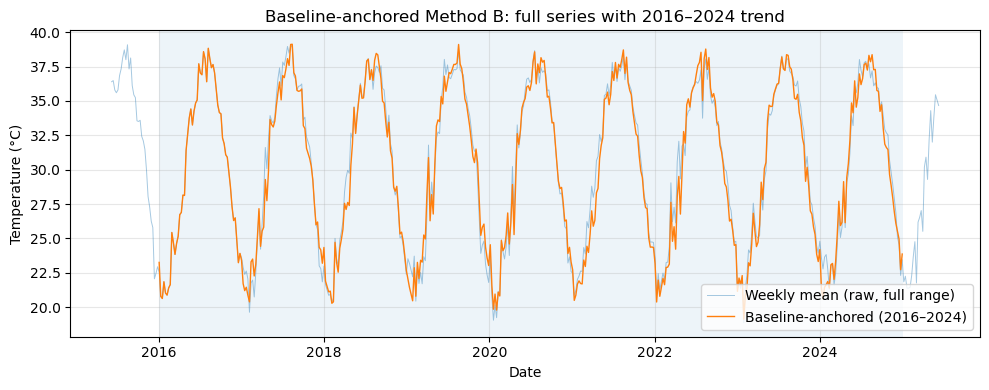

In [33]:
# Method C: Baseline anchoring by month (no linearity assumption).
base_year = 2016

# monthly mean for each (year, month)
ym_mean = df.groupby(['year','month'])['temperature_C'].mean().rename('ym_mean').reset_index()
# baseline monthly mean
base = ym_mean[ym_mean['year'] == base_year][['month','ym_mean']].rename(columns={'ym_mean':'base_mean'})

# merge and compute offset = current month mean minus baseline month mean
off = ym_mean.merge(base, on='month')
off['offset'] = off['ym_mean'] - off['base_mean']
off = off[['year','month','offset']]

# apply offset to each observation
df2 = df.merge(off, on=['year','month'], how='left')
df2['temp_adj'] = df2['temperature_C'] - df2['offset']

# plot offsets
weekly_raw = df2.set_index('dt')['temperature_C'].resample('W').mean()
weekly_adj = df2.set_index('dt')['temp_adj'].resample('W').mean()

# slice for the fit (avoiding partial 2015/2025)
start, end = '2016-01-01', '2024-12-31'
weekly_adj_slice = weekly_adj.loc[start:end].interpolate(limit_direction='both')

# --- plot: full raw background + anchored slice---
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(weekly_raw.index, weekly_raw.values, linewidth=0.7, alpha=0.4,
        label='Weekly mean (raw, full range)')


ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), alpha=0.08)


ax.plot(weekly_adj_slice.index, weekly_adj_slice.values, linewidth=1.0,
        label='Baseline-anchored (2016–2024)')

loc = AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(ConciseDateFormatter(loc))
ax.set_xlabel('Date'); ax.set_ylabel('Temperature (°C)')
ax.set_title('Baseline-anchored Method B: full series with 2016–2024 trend')
ax.grid(True, alpha=0.3); ax.legend()
plt.tight_layout(); plt.show()

In [38]:
# Results 
TSI = 10_000_000
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
thresholds = [35.0, 40.0, 45.0]

has_adj = "temp_adj" in df2.columns # using Method C adjustments
w = 12  # column width for numbers

def fmt(x):
    # show in millions with 2 decimals, e.g. 12.34 M
    return f"{x/1_000_000:,.2f} M"

# -------- header --------
line1 = f"{'Year':<6} | " + " | ".join(f"{f'{thr:.0f}°C':^{w*2+1}}" if has_adj else f"{f'{thr:.0f}°C':^{w}}"
                                      for thr in thresholds)
line2 = f"{'':<6} | " + " | ".join(("Raw".rjust(w) + " " + "Adj".rjust(w)) if has_adj else "Raw".rjust(w)
                                   for _ in thresholds)
rule  = "-" * len(line1)

print(line1)
if has_adj:
    print(line2)
print(rule)

# -------- rows --------
for y in years:
    raw_series = df.loc[df["year"] == y, "temperature_C"].dropna().tolist()
    adj_series = df2.loc[df["year"] == y, "temp_adj"].dropna().tolist() if has_adj else None

    cells = []
    for thr in thresholds:
        raw_pay = calculate_insurance_payout(raw_series, thr, TSI)
        if has_adj:
            adj_pay = calculate_insurance_payout(adj_series, thr, TSI)
            cells.append(f"{fmt(raw_pay):>{w}} {fmt(adj_pay):>{w}}")
        else:
            cells.append(f"{fmt(raw_pay):>{w}}")

    print(f"{y:<6} | " + " | ".join(cells))

Year   |           35°C            |           40°C            |           45°C           
       |          Raw          Adj |          Raw          Adj |          Raw          Adj
------------------------------------------------------------------------------------------
2015   |     254.50 M     234.00 M |       4.50 M       3.50 M |       0.00 M       0.00 M
2016   |     229.50 M     229.50 M |       9.50 M       9.50 M |       0.00 M       0.00 M
2017   |     276.50 M     219.00 M |      12.50 M       9.00 M |       0.00 M       0.00 M
2018   |     227.00 M     242.50 M |       5.00 M       6.50 M |       0.00 M       0.00 M
2019   |     249.00 M     236.00 M |       7.00 M       4.50 M |       0.00 M       0.00 M
2020   |     233.00 M     260.50 M |       1.00 M       1.00 M |       0.00 M       0.00 M
2021   |     232.50 M     230.00 M |       2.50 M       3.50 M |       0.00 M       0.00 M
2022   |     180.50 M     294.50 M |       1.00 M       4.00 M |       0.00 M       0.00 M

**QUESTION 2**

In [35]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

rng = np.random.default_rng(123)

def draw_student_t_unit_var(size, nu, rng):
    """Student-t(ν) with unit variance (ν>2). If nu==np.inf -> N(0,1)."""
    if np.isinf(nu):
        return rng.normal(size=size)
    z = rng.normal(size=size)
    chi2 = rng.chisquare(nu, size=size)
    return (z / np.sqrt(chi2 / nu)) / np.sqrt(nu / (nu - 2.0))

def vectorized_payout(temps, thr, TSI):
    """
    temps: (n_years, T_hours)
    Rule: +5% TSI for every 7-hour window all > threshold (overlaps allowed).
    """
    b = temps > thr
    csum = np.concatenate([np.zeros((b.shape[0], 1), dtype=np.int32),
                           b.cumsum(axis=1, dtype=np.int32)], axis=1)
    win7 = csum[:, 7:] - csum[:, :-7]
    counts = (win7 == 7).sum(axis=1)
    return counts * 0.05 * TSI

# ====== 1) Data prep (expects df with columns: datetime_str, temperature_C) ======
d0 = df.copy()
d0['dt']    = pd.to_datetime(d0['datetime_str'])
d0['year']  = d0['dt'].dt.year
d0['month'] = d0['dt'].dt.month
d0['hour']  = d0['dt'].dt.hour

CAL_START, CAL_END = 2016, 2024
base_year = CAL_START
cal = d0[(d0['year'] >= CAL_START) & (d0['year'] <= CAL_END)].dropna(subset=['temperature_C']).copy()

day_hours = sorted(cal['hour'].unique())
hot_months = [5, 6, 7, 8, 9] # months considered "hot"

# ====== 2) Calibrate: trend β (°C/yr), seasonal μ(m,h), σ(m,h) ======
cal['t_years'] = (cal['dt'] - cal['dt'].min()).dt.total_seconds() / (365.25 * 24 * 3600)

# Use formula interface to keep named coefficients and avoid dtype issues
cal2 = cal[['temperature_C', 't_years', 'month', 'hour']].replace([np.inf, -np.inf], np.nan).dropna()
ols = smf.ols('temperature_C ~ t_years + C(month) + C(hour)', data=cal2)\
         .fit(cov_type='HAC', cov_kwds={'maxlags': 24 * 14})
beta_per_year = float(ols.params['t_years'])  # warming slope from data

# Detrend to base_year, then monthly-hourly climatology
cal['temp_detr'] = cal['temperature_C'] - beta_per_year * (cal['year'] - base_year)
clim = (cal.groupby(['month', 'hour'])['temp_detr'].mean()
          .rename('clim').reset_index())

# Residuals around μ(m,h) + linear trend
cal = cal.merge(clim, on=['month', 'hour'], how='left')
cal['resid'] = cal['temperature_C'] - (cal['clim'] + beta_per_year * (cal['year'] - base_year))

# Heteroskedastic σ(m,h)
sigma = (cal.groupby(['month', 'hour'])['resid'].std(ddof=1)
           .rename('sigma').reset_index())
overall_sigma = float(cal['resid'].std(ddof=1))

# Diagnostics (not used directly)
ratio_hot_cool = float(
    cal.loc[cal['month'].isin(hot_months), 'resid'].std(ddof=1) /
    cal.loc[~cal['month'].isin(hot_months), 'resid'].std(ddof=1)
)

# ====== 3) Persistence φ on standardized residuals (hot months, consecutive hours) ======
dd = cal.merge(sigma, on=['month', 'hour'], how='left', suffixes=('', '_s'))
dd['sigma'] = dd['sigma'].replace(0, np.nan).fillna(overall_sigma)
dd['u'] = dd['resid'] / dd['sigma']
dd = dd.sort_values('dt')

hot_dd = dd[dd['month'].isin(hot_months)].copy()
is_consec = hot_dd['dt'].diff().dt.total_seconds().eq(3600)  # true 1-hour steps only
u_prev = hot_dd['u'].shift(1).loc[is_consec].to_numpy()
u_curr = hot_dd.loc[is_consec, 'u'].to_numpy()

phi = np.corrcoef(u_prev, u_curr)[0, 1] if (u_prev.size and u_curr.size) else 0.0
phi = float(np.clip(0.0 if np.isnan(phi) else phi, 0.0, 0.99))

# ====== 4) Heavy tails ν from standardized residuals ======
uk = pd.Series(dd['u']).dropna()
m = uk.mean()
c = uk - m
m2 = float(np.mean(c**2))
m4 = float(np.mean(c**4))
ex_kurt = (m4 / (m2**2)) - 3.0 if m2 > 0 else 0.0
if ex_kurt > 0:
    nu_est = float(max(4.0 + 6.0 / ex_kurt, 3.01))  # moment-match, ensure ν>3
else:
    nu_est = np.inf

print(f"Calibrated: beta={beta_per_year:.3f} °C/yr, φ={phi:.2f}, ν≈{np.inf if np.isinf(nu_est) else nu_est:.1f}, hot/cool σ≈{ratio_hot_cool:.2f}")

# ====== 5) Simulator: AR(1)+t using μ(m,h)+β·Δyear and σ(m,h) ======
def simulate_payouts_AR1_t(target_year, N, thr, TSI, rng, batch=2000,
                           beta=beta_per_year, base_year=base_year,
                           clim=clim, sigma=sigma, phi=phi, nu=nu_est,
                           day_hours=day_hours, sigma_hot_scale=1.0, sigma_cool_scale=1.0,
                           gap_aware=True):
    # Build daytime-only hourly index for the target year
    idx = pd.date_range(f'{target_year}-01-01', f'{target_year}-12-31 23:00', freq='H')
    idx = idx[idx.hour.isin(day_hours)]
    months = idx.month.values
    hours  = idx.hour.values
    years  = idx.year.values
    key = pd.MultiIndex.from_arrays([months, hours], names=['month','hour'])

    # Mean and std lookups
    clim_s  = clim.set_index(['month','hour'])['clim']
    sigma_s = sigma.set_index(['month','hour'])['sigma']
    mu  = clim_s.reindex(key).to_numpy() + beta * (target_year - base_year)
    sig = sigma_s.reindex(key).to_numpy()
    sig = np.where(np.isfinite(sig), sig, overall_sigma)

    # Hot/cool scaling
    is_hot = np.isin(months, hot_months)
    sig *= np.where(is_hot, sigma_hot_scale, sigma_cool_scale)

    T = len(idx)
    annual = np.empty(N, dtype=float)

    # Precompute gap multipliers (same time grid for all simulated paths)
    if gap_aware:
        k = np.r_[1, np.diff(idx.values).astype('timedelta64[h]').astype(int)]
        a = np.clip(phi, 0.0, 0.99) ** k
        sqrt_1m_a2 = np.sqrt(1.0 - a*a)
    else:
        a = np.full(T, np.clip(phi, 0.0, 0.99), dtype=float)
        sqrt_1m_a2 = np.sqrt(1.0 - a*a)

    for start in range(0, N, batch):
        bsz = min(batch, N - start)
        e = draw_student_t_unit_var(size=(bsz, T), nu=nu, rng=rng)   # unit-variance innovations

        # AR(1) with (optional) gap adjustment
        u = np.empty_like(e)
        u[:, 0] = e[:, 0]
        for t in range(1, T):
            u[:, t] = a[t] * u[:, t-1] + sqrt_1m_a2[t] * e[:, t]

        temps = mu + u * sig
        annual[start:start+bsz] = vectorized_payout(temps, thr, TSI)

    return annual

# ====== 6) Example run for 2045 ======
TSI = 10_000_000
thr = 45.0
target_eval_year = 2045
N = 50_000

# Considering a scenario of 0.05 °C increase per year.
annual = simulate_payouts_AR1_t(target_eval_year, N, thr, TSI, rng, beta = 0.05)

p99  = float(np.quantile(annual, 0.99))
p995 = float(np.quantile(annual, 0.995))  # 1-in-200 in 20 years time
print(f"Target {target_eval_year}: mean €{annual.mean():,.0f}, "
      f"median €{np.median(annual):,.0f}, p99 €{p99:,.0f}, p99.5 €{p995:,.0f}")

# ====== 6) Example run for 2125 ======
TSI = 10_000_000
thr = 45.0
target_eval_year = 2125
N = 50_000

annual = simulate_payouts_AR1_t(target_eval_year, N, thr, TSI, rng, beta = 0.05)

p99  = float(np.quantile(annual, 0.99))
p995 = float(np.quantile(annual, 0.995))  # 1-in-200 in 20 years time
print(f"Target {target_eval_year}: mean €{annual.mean():,.0f}, "
      f"median €{np.median(annual):,.0f}, p99 €{p99:,.0f}, p99.5 €{p995:,.0f}")


Calibrated: beta=0.018 °C/yr, φ=0.98, ν≈18.9, hot/cool σ≈0.79


/var/folders/my/7zs3bwd5187d9h06fcjxvlkr0000gn/T/ipykernel_49372/2016407753.py:104: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(f'{target_year}-01-01', f'{target_year}-12-31 23:00', freq='H')


Target 2045: mean €5,660, median €0, p99 €0, p99.5 €500,000
Target 2125: mean €6,836,840, median €6,500,000, p99 €18,000,000, p99.5 €19,500,000


/var/folders/my/7zs3bwd5187d9h06fcjxvlkr0000gn/T/ipykernel_49372/3345045584.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(seam + pd.Timedelta(hours=1), '2045-12-31 23:00', freq='H')


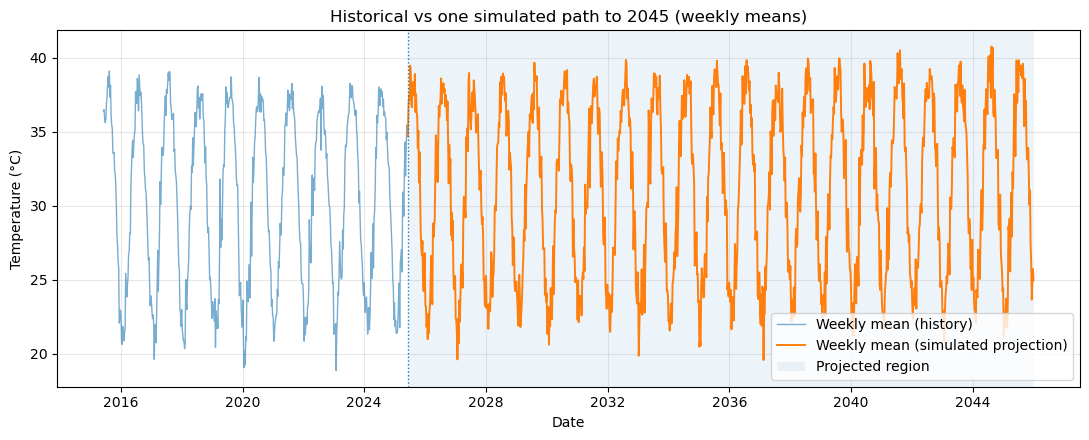

In [36]:
# --- 1) build one simulated path from last historical timestamp to 2045 ---
def simulate_path_to_2045(beta=0.05, sigma_hot_scale=1.0, sigma_cool_scale=1.0, rng=rng):
    """
    Returns a DataFrame with dt and temperature_C_sim for the projection part only.
    Uses your calibrated clim, sigma, phi, nu_est, base_year, day_hours, hot_months.
    """

    # seam at last observed hour
    seam = d0['dt'].max()
    idx = pd.date_range(seam + pd.Timedelta(hours=1), '2045-12-31 23:00', freq='H')
    idx = idx[idx.hour.isin(day_hours)]

    m = idx.month.values
    h = idx.hour.values
    y = idx.year.values
    key = pd.MultiIndex.from_arrays([m, h], names=['month','hour'])

    # lookups
    clim_s  = clim.set_index(['month','hour'])['clim']
    sigma_s = sigma.set_index(['month','hour'])['sigma']

    mu  = clim_s.reindex(key).to_numpy() + beta * (y - base_year)
    sig = sigma_s.reindex(key).to_numpy()
    sig = np.where(np.isfinite(sig), sig, overall_sigma)

    # hot/cool scaling
    is_hot = np.isin(m, hot_months)
    sig *= np.where(is_hot, sigma_hot_scale, sigma_cool_scale)

    # AR(1) with gaps: u_t = φ^k u_{t-1} + sqrt(1-φ^{2k}) e_t  (unit-var innovations)
    T = len(idx)
    e = draw_student_t_unit_var(size=T, nu=nu_est, rng=rng)
    u = np.empty(T, dtype=float)
    u[0] = e[0]

    # gap in hours between consecutive kept points (daytime series has overnight gaps)
    k = np.r_[1, np.diff(idx.values).astype('timedelta64[h]').astype(int)]
    a = np.clip(phi, 0.0, 0.99) ** k
    for t in range(1, T):
        u[t] = a[t] * u[t-1] + np.sqrt(max(1.0 - a[t]*a[t], 0.0)) * e[t]

    temps = mu + u * sig
    return pd.DataFrame({'dt': idx, 'temperature_C_sim': temps})

# Scenario 0.05 °C/yr
path = simulate_path_to_2045(beta=0.05)

# --- 2) plot history (weekly mean) + simulated projection (weekly mean) ---
hist = d0.set_index('dt')['temperature_C'].resample('W').mean()

fig, ax = plt.subplots(figsize=(11,4.5))
ax.plot(hist.index, hist.values, lw=1.0, alpha=0.6, label='Weekly mean (history)')

proj_weekly = path.set_index('dt')['temperature_C_sim'].resample('W').mean()
ax.plot(proj_weekly.index, proj_weekly.values, lw=1.4, label='Weekly mean (simulated projection)')

seam = d0['dt'].max()
ax.axvline(seam, ls=':', lw=1)
ax.axvspan(seam, proj_weekly.index.max(), alpha=0.08, label='Projected region')


loc = AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(ConciseDateFormatter(loc))
ax.set_xlabel('Date'); ax.set_ylabel('Temperature (°C)')
ax.set_title('Historical vs one simulated path to 2045 (weekly means)')
ax.grid(True, alpha=0.3); ax.legend()
plt.tight_layout(); plt.show()